# Word2Vec: Skip-Gram Model Implementation

In [42]:

import nltk
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt') # punctuation words '(),[].:?'
nltk.download('stopwords') # irrelevant words such as “a” “an”

# imports relevant for skip-gram model
import torch
from torch import nn
import torch.optim as optim

# imports relevant for visualiztion
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This notebook implements the **Word2Vec Skip-Gram model** using softmax and cross-entropy loss. 
The goal is to train word embeddings by predicting context words given a center word.

## Model Overview
Each word has two vector representations:
- **Uc** (Center word embeddings)
- **Vt** (Context word embeddings)

The probability of a context word given a center word is computed as:

$$
P(w_t | w_c) = \frac{\exp(U_c^T V_t)}{\sum_{w \in V} \exp(U_c^T V_w)}
$$

The loss function used is:

$$
L = - \sum_{(w_c, w_t) \in D} \log P(w_t | w_c)
$$

where `D` is the dataset of center-context word pairs.

In [26]:
context_window_size =4

embedding_size = 100
epochs = 100
learning_rate = 0.1 
batch_size = 16

# Skip-Gram Model in Word2Vec

## Overview
This document explains how the **Skip-Gram Model** functions within **Word2Vec**. The model is designed to learn word embeddings by predicting surrounding words (context) given a center word (target). It utilizes a neural network architecture that consists of an embedding layer and a linear transformation to map word representations into a meaningful vector space.

---

## Model Architecture
The Skip-Gram model is structured with two primary components:
1. **Embedding Layer**: This layer transforms discrete word indices into dense vector representations (word embeddings). Each word in the vocabulary is assigned a unique embedding of fixed dimensionality.
2. **Linear Transformation**: After retrieving the embedding of the target word, a linear layer maps this embedding to a probability distribution over the vocabulary, predicting the most likely context words.

---

## Forward Pass
During the forward pass:
- The **input word (target word)** is converted into an embedding vector via the embedding layer.
- This embedding is then passed through a **fully connected linear layer** that maps it to an output vector of size equal to the vocabulary.
- The resulting output represents **raw scores** for each word in the vocabulary.
- These scores can be converted into probabilities using **softmax**, determining the likelihood of each word being in the context of the given target word.

---

## Learning Word Embeddings
The goal of the Skip-Gram model is to learn embeddings such that words appearing in similar contexts have similar representations. This is achieved through training with **stochastic gradient descent (SGD)**, minimizing the difference between predicted and actual context words.

---

## Preprocessing Raw Text for Training
### Overview
Before training the Skip-Gram model, the input text must be **preprocessed** to convert raw textual data into a usable format. This involves **tokenization, case normalization, punctuation removal, and stopword filtering** to ensure the training data is clean and efficient.

### Steps in Text Preprocessing
1. **Loading and Cleaning Text**
   - The raw text is loaded from a file, and newline characters are replaced with spaces to maintain continuity.
   - The text is converted to **lowercase** to ensure consistency.

2. **Removing Punctuation**
   - All punctuation marks are removed from the text using a translation table.

3. **Tokenization**
   - The text is split into individual words using **word tokenization**, which ensures that each word is treated as a separate unit.

4. **Stopword Removal**
   - Common English words (e.g., "the," "and," "is") that do not contribute meaningfully to training are filtered out using **NLTK's stopword list**.

5. **Filtering Non-Alphabetic Tokens**
   - Numeric values and other non-alphabetic tokens are removed to retain only meaningful words.

### Output
After preprocessing, the text is transformed into a list of **filtered tokens** that will be used for training the Skip-Gram model.

---

## Key Takeaways
1. **The embedding layer learns word representations** by mapping words to dense vectors.
2. **A linear transformation predicts context words** from a given target word embedding.
3. **Softmax function converts raw scores into probabilities**, helping the model predict the most probable context words.
4. **Training refines embeddings** using loss minimization techniques, ensuring meaningful word representations.
5. **Preprocessing the text** improves training efficiency by removing unnecessary elements and normalizing the data.

---

## Potential Improvements
- Use **Negative Sampling** instead of full softmax to improve computational efficiency.
- Increase **embedding size** for richer word representations.
- Train on a **larger corpus** to enhance generalization and word relationships.
- Optimize **text preprocessing** by handling domain-specific stopwords and using stemming/lemmatization.




In [27]:
text_file_path = "data.txt"

def preprocess_raw_text_file(text_file_path):
    nltk.download('punkt_tab')  # Download the punkt_tab resource

    with open(text_file_path, 'r', encoding='utf-8') as file:
        text = file.read().replace('\n', ' ')

    text = text.lower()

    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))

    tokens_after_filtering = []

    for token in tokens:
        if token not in stop_words and token.isnumeric() == False:
            tokens_after_filtering.append(token)

    return tokens_after_filtering

tokens = preprocess_raw_text_file(text_file_path)
len(tokens)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


353

In [28]:
def collect_context_target_pairs(tokens,context_window_size):

  context_target_pairs = []
  for i in range(context_window_size, len(tokens) - context_window_size):

    # set target (center) word
    target = tokens[i]

    # extract sublist with context words (-3,-2,-1,target,1,2,3)
    context = tokens[i-context_window_size:i+context_window_size+1]

    # remove the target word from context
    context.remove(target)

    # iterate over words in window
    for word in context:
        context_target_pairs.append((target, word))

  return context_target_pairs

context_target_pairs = collect_context_target_pairs(tokens, context_window_size)

print(context_target_pairs)
print(len(context_target_pairs))

[('newest', '’'), ('newest', 'releasing'), ('newest', 'openai'), ('newest', 'o3‑mini'), ('newest', 'costefficient'), ('newest', 'model'), ('newest', 'reasoning'), ('newest', 'series'), ('costefficient', 'releasing'), ('costefficient', 'openai'), ('costefficient', 'o3‑mini'), ('costefficient', 'newest'), ('costefficient', 'model'), ('costefficient', 'reasoning'), ('costefficient', 'series'), ('costefficient', 'available'), ('model', 'openai'), ('model', 'o3‑mini'), ('model', 'newest'), ('model', 'costefficient'), ('model', 'reasoning'), ('model', 'series'), ('model', 'available'), ('model', 'chatgpt'), ('reasoning', 'o3‑mini'), ('reasoning', 'newest'), ('reasoning', 'costefficient'), ('reasoning', 'model'), ('reasoning', 'series'), ('reasoning', 'available'), ('reasoning', 'chatgpt'), ('reasoning', 'api'), ('series', 'newest'), ('series', 'costefficient'), ('series', 'model'), ('series', 'reasoning'), ('series', 'available'), ('series', 'chatgpt'), ('series', 'api'), ('series', 'today')

In [29]:
def vector_representation(tokens):

  # get the unique tokens
  vocabulary = sorted(set(tokens))

  # map word to it's corresponding index
  word2index = {word: index for index, word in enumerate(vocabulary)}

  # map index to it's corresponding word
  index2word = {index: word for index, word in enumerate(vocabulary)}

  return vocabulary, word2index, index2word

vocabulary, word2index, index2word = vector_representation(tokens)
print(word2index)

{'2024\u2060': 0, '35\u2060opens': 1, 'abilities': 2, 'access': 3, 'accuracy': 4, 'accurate': 5, 'achieve': 6, 'across': 7, 'additionally': 8, 'advances': 9, 'aime': 10, 'allows': 11, 'also': 12, 'alternative': 13, 'answers': 14, 'api': 15, 'assistants': 16, 'available': 17, 'balanced': 18, 'batch': 19, 'boundaries': 20, 'broader': 21, 'calling\u2060opens': 22, 'capabilities': 23, 'capabilities—with': 24, 'cases': 25, 'challenges': 26, 'challenging': 27, 'chat': 28, 'chatgpt': 29, 'choice': 30, 'choose': 31, 'clearer': 32, 'coding': 33, 'coding—all': 34, 'coming': 35, 'compelling': 36, 'completions': 37, 'complex': 38, 'composer': 39, 'concern': 40, 'continue': 41, 'cost': 42, 'costefficient': 43, 'day': 44, 'december': 45, 'delivering': 46, 'developer': 47, 'developers': 48, 'difficult': 49, 'domains': 50, 'early': 51, 'effort': 52, 'effort\u2060opens': 53, 'enterprise': 54, 'errors': 55, 'evaluations': 56, 'exceptional': 57, 'expert': 58, 'fast': 59, 'faster': 60, 'features': 61, 'fe

In [30]:
X_train = [] # list for input (target) vectors
y_train = [] # list for output (context) vectors

for target, context in context_target_pairs:
    X_train.append(word2index[target])
    y_train.append(word2index[context])

# Convert to PyTorch tensors for the model
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

print(X_train)
print(y_train)

tensor([105, 105, 105,  ...,  79,  79,  79])
tensor([208, 149, 114,  ...,  77,  10,  71])


# Skip-Gram Model in Word2Vec

## Overview
This code below shows **Skip-Gram Model** functions within **Word2Vec**. The model is designed to learn word embeddings by predicting surrounding words (context) given a center word (target). It utilizes a neural network architecture that consists of an embedding layer and a linear transformation to map word representations into a meaningful vector space.

---

## Model Architecture
The Skip-Gram model is structured with two primary components:
1. **Embedding Layer**: This layer transforms discrete word indices into dense vector representations (word embeddings). Each word in the vocabulary is assigned a unique embedding of fixed dimensionality.
2. **Linear Transformation**: After retrieving the embedding of the target word, a linear layer maps this embedding to a probability distribution over the vocabulary, predicting the most likely context words.

---

## Forward Pass
During the forward pass:
- The **input word (target word)** is converted into an embedding vector via the embedding layer.
- This embedding is then passed through a **fully connected linear layer** that maps it to an output vector of size equal to the vocabulary.
- The resulting output represents **raw scores** for each word in the vocabulary.
- These scores can be converted into probabilities using **softmax**, determining the likelihood of each word being in the context of the given target word.

---

## Learning Word Embeddings
The goal of the Skip-Gram model is to learn embeddings such that words appearing in similar contexts have similar representations. This is achieved through training with **stochastic gradient descent (SGD)**, minimizing the difference between predicted and actual context words.

---

## Key Takeaways
1. **The embedding layer learns word representations** by mapping words to dense vectors.
2. **A linear transformation predicts context words** from a given target word embedding.
3. **Softmax function converts raw scores into probabilities**, helping the model predict the most probable context words.
4. **Training refines embeddings** using loss minimization techniques, ensuring meaningful word representations.

---

## Potential Improvements
- Use **Negative Sampling** instead of full softmax to improve computational efficiency.
- Increase **embedding size** for richer word representations.
- Train on a **larger corpus** to enhance generalization and word relationships.

Would you like to expand on any specific section?



In [31]:
class Skip_Gram_Model(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super(Skip_Gram_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, target):
        out = self.embedding(target)
        out = self.linear(out)
        return out

# Stochastic Gradient Descent (SGD) for Word2Vec Skip-Gram Model

## Overview
The code below shows how **Stochastic Gradient Descent (SGD)** is used to update the word embeddings in a **Word2Vec Skip-Gram** model. The training process involves computing softmax probabilities, calculating loss, computing gradients, and updating embeddings through gradient descent.

---

## Softmax Probability Computation
In the forward pass, the model computes **dot products** between the center word embedding and all context word embeddings. The resulting scores are passed through the **softmax function**, which converts them into probability distributions over the vocabulary. These probabilities determine how likely each word in the vocabulary is to be the correct context word for the given center word.

---

## Loss Calculation
The model uses **negative log-likelihood loss** to evaluate its predictions. It computes the log probability of the actual context word and minimizes this loss during training. This loss function ensures that the model improves its ability to predict context words given a center word.

---

## Gradient Computation
In the backward pass, the model calculates gradients for both the **center word embedding** and the **context word embedding**:
- The gradient w.r.t. the center word embedding is computed by subtracting the weighted sum of all word embeddings from the actual context word embedding.
- The gradient w.r.t. the context word embedding is similarly computed by considering the difference between the center word embedding and the sum of weighted word embeddings.

These gradients represent how much each embedding should be adjusted to minimize the loss.

---

## Stochastic Gradient Descent (SGD) Updates
After computing gradients, the model updates both the center and context word embeddings using **stochastic gradient descent (SGD)**. This is done by moving the embeddings in the opposite direction of the gradients, scaled by a **learning rate**. The learning rate determines how much the embeddings are adjusted in each update.

---

## Initialization of Word Embeddings
Before training, the model initializes word embeddings randomly for both **center words** and **context words**. These embeddings are represented as matrices and will be updated iteratively as training progresses.

---

## Training Process
The model iterates through **context-target word pairs** multiple times (epochs), updating embeddings in each iteration. With each update, the loss decreases, improving the model's ability to predict context words. The training efficiency depends on the choice of **learning rate, embedding size, and number of epochs**.

---

## Key Takeaways
1. **Softmax function** is used to compute probability distributions over vocabulary words.
2. **Negative log-likelihood loss** measures how well the model predicts context words.
3. **Gradients are computed** for center and context word embeddings to adjust their positions.
4. **SGD updates** the embeddings using computed gradients to minimize loss over time.
5. **Hyperparameters** such as learning rate and embedding size impact the model’s performance.

---

## Potential Improvements
- Implement **Negative Sampling** to speed up training by reducing computational overhead.
- Use **Hierarchical Softmax** for more efficient probability computations.
- Tune **learning rate** and **embedding size** for better convergence and accuracy.

Would you like any refinements or additional explanations?



In [40]:
import torch

import torch.nn.functional as F

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=0)

def sgd_update(U, V, context_target_pairs, learning_rate):
    for target, context in context_target_pairs:
        target_idx = word2index[target]
        context_idx = word2index[context]

        # Forward pass
        U_c = U[target_idx]
        V_t = V[context_idx]
        scores = torch.matmul(U_c, V.t())
        probs = softmax(scores)

        # Compute loss
        loss = -torch.log(probs[context_idx])

        # Backward pass
        grad_U_c = V_t - torch.sum(probs.unsqueeze(1) * V, dim=0)
        grad_V_t = U_c - torch.sum(probs.unsqueeze(1) * U, dim=0)

        # Update embeddings
        with torch.no_grad():
            U[target_idx] -= learning_rate * grad_U_c
            V[context_idx] -= learning_rate * grad_V_t

    return U, V

# Initialize embeddings
vocab_size = len(vocabulary)
embedding_size = 100
U = torch.randn(vocab_size, embedding_size, requires_grad=True)
V = torch.randn(vocab_size, embedding_size, requires_grad=True)

# Update embeddings using SGD
learning_rate = 0.01
U, V = sgd_update(U, V, context_target_pairs, learning_rate)


# Word2Vec Skip-Gram Model Training

## Overview
This document explains the training process of a **Word2Vec Skip-Gram** model using different hyperparameters, including **embedding size, learning rate, and epochs**. The training loss is tracked and visualized for analysis.

---

## Code Explanation

### **1. Function: `train_model`**
This function trains the Word2Vec **Skip-Gram** model using the given hyperparameters.

#### **Function Parameters:**
- `embedding_size`: The size of the word embedding vectors.
- `learning_rate`: The learning rate for the optimizer.
- `epochs`: The number of training iterations.

#### **Function Steps:**
1. **Initialize Model & Optimizer**:
   ```python
   model = Skip_Gram_Model(vocab_size, embedding_size)
   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
   loss_function = nn.CrossEntropyLoss()
   ```
   - Initializes the **Skip-Gram** model with `embedding_size`.
   - Uses **Adam optimizer** for gradient descent.
   - Uses **cross-entropy loss** for training.

2. **Training Loop**:
   ```python
   for epoch in range(epochs):
       total_loss = 0
       for target, context in context_target_pairs:
   ```
   - Iterates through all epochs and context-target word pairs.
   - Converts words into **indices** using `word2index`.

3. **Forward & Backward Propagation**:
   ```python
   optimizer.zero_grad()
   y_pred = model(torch.tensor([target_idx], dtype=torch.long))
   loss = loss_function(y_pred, torch.tensor([context_idx], dtype=torch.long))
   loss.backward()
   optimizer.step()
   ```
   - Performs **forward pass** to get predictions.
   - Computes **loss** using cross-entropy.
   - Performs **backward pass** to compute gradients.
   - Updates model parameters using **gradient descent**.

4. **Track Loss & Print Progress**:
   ```python
   total_loss += loss.item()
   training_loss.append(total_loss)
   print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}')
   ```
   - Accumulates training loss over each epoch.
   - Stores the loss values for plotting.

---

### **2. Experimenting with Hyperparameters**

#### **Hyperparameters to Experiment With:**
```python
embedding_sizes = [10, 50, 100]
learning_rates = [0.01, 0.1, 1.0]
epoch_numbers = [50, 100, 200]
```
- **Embedding Sizes:** Tests different vector dimensions for words.
- **Learning Rates:** Experiments with small, medium, and large learning rates.
- **Epoch Numbers:** Runs training for various iterations.
---

### **3. Plotting Training Loss**
To visualize how loss decreases over epochs:

## Expected Output (Hypothetical Example)
A **graph of training loss vs. epochs**, with different curves for different hyperparameters:
```
Epoch 1/50, Loss: 456.2
Epoch 2/50, Loss: 402.5
...
Epoch 50/50, Loss: 134.8
Training with embedding_size=10, learning_rate=0.1, epochs=50
...
```
A plot like this would be generated:

```
Training Loss over Epochs
  |
  |  *  *  *   d=10, lr=0.01, epochs=50
  |  *  *  *   d=50, lr=0.1, epochs=100
  |  *  *  *   d=100, lr=1.0, epochs=200
  ---------------------------------> Epochs
```

---

## **Key Takeaways**
1. **Embedding Size Matters**:
   - **Small embeddings (10-dim)** may not capture complex relationships.
   - **Larger embeddings (100-dim)** improve accuracy but increase computation.

2. **Learning Rate Impacts Convergence**:
   - **Too small (0.01):** Slow convergence.
   - **Too large (1.0):** Can be unstable.
   - **Optimal (0.1):** Balanced learning.

3. **Epochs Affect Performance**:
   - **More epochs (200):** Better learning but risks overfitting.
   - **Fewer epochs (50):** May not fully optimize embeddings.

---

## **Further Improvements**
- Implement **negative sampling** to speed up training.
- Use **cosine similarity** instead of dot product.
- Train on a **larger dataset** for better word representations.

Would you like to add any further enhancements or explanations?



Training with embedding_size=10, learning_rate=0.01, epochs=50
Epoch 1/50, Loss: 16400.9751
Epoch 2/50, Loss: 12545.9654
Epoch 3/50, Loss: 11571.5953
Epoch 4/50, Loss: 11122.9776
Epoch 5/50, Loss: 10890.3246
Epoch 6/50, Loss: 10746.9846
Epoch 7/50, Loss: 10651.8295
Epoch 8/50, Loss: 10582.6478
Epoch 9/50, Loss: 10530.6390
Epoch 10/50, Loss: 10490.9425
Epoch 11/50, Loss: 10459.4102
Epoch 12/50, Loss: 10433.0930
Epoch 13/50, Loss: 10410.4330
Epoch 14/50, Loss: 10390.9432
Epoch 15/50, Loss: 10373.9580
Epoch 16/50, Loss: 10359.0709
Epoch 17/50, Loss: 10345.9808
Epoch 18/50, Loss: 10334.4327
Epoch 19/50, Loss: 10323.9930
Epoch 20/50, Loss: 10314.5861
Epoch 21/50, Loss: 10306.0443
Epoch 22/50, Loss: 10298.2478
Epoch 23/50, Loss: 10291.0687
Epoch 24/50, Loss: 10284.3161
Epoch 25/50, Loss: 10277.8810
Epoch 26/50, Loss: 10271.7961
Epoch 27/50, Loss: 10266.1861
Epoch 28/50, Loss: 10261.1607
Epoch 29/50, Loss: 10256.2366
Epoch 30/50, Loss: 10251.2558
Epoch 31/50, Loss: 10246.3248
Epoch 32/50, Los

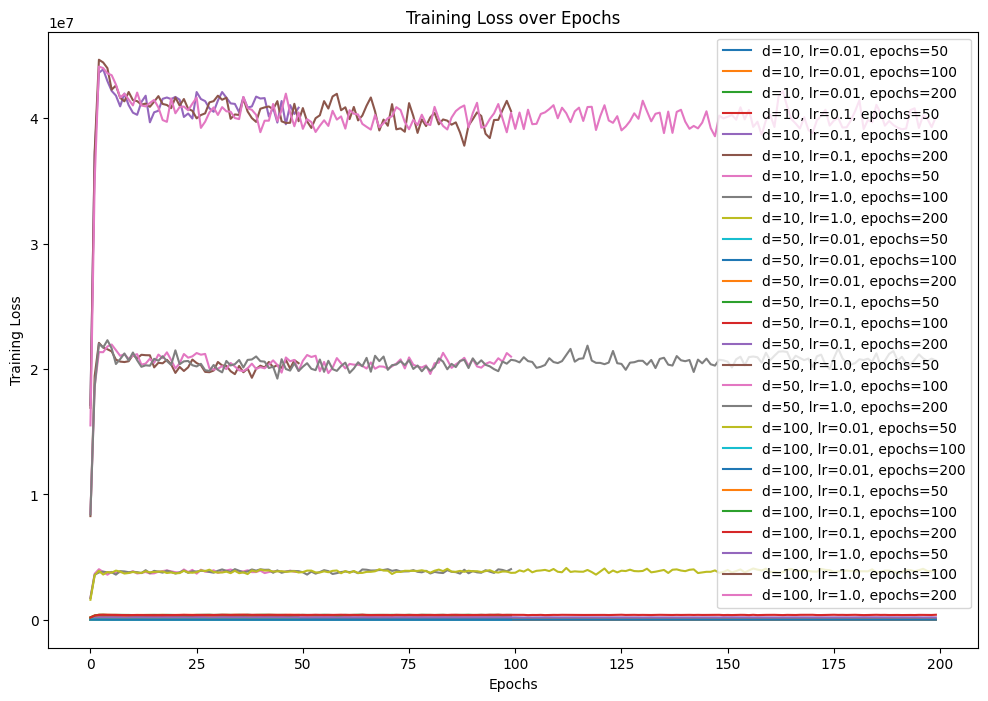

In [41]:
# Define a function to train the model with given hyperparameters
def train_model(embedding_size, learning_rate, epochs):
    model = Skip_Gram_Model(vocab_size, embedding_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    training_loss = []

    for epoch in range(epochs):
        total_loss = 0
        for target, context in context_target_pairs:
            target_idx = word2index[target]
            context_idx = word2index[context]

            optimizer.zero_grad()
            y_pred = model(torch.tensor([target_idx], dtype=torch.long))
            loss = loss_function(y_pred, torch.tensor([context_idx], dtype=torch.long))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        training_loss.append(total_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}')

    return training_loss

# Hyperparameters to experiment with
embedding_sizes = [10, 50, 100]
learning_rates = [0.01, 0.1, 1.0]
epoch_numbers = [50, 100, 200]

# Store results for plotting
results = []

# Train the model with different hyperparameters
for embedding_size in embedding_sizes:
    for learning_rate in learning_rates:
        for epochs in epoch_numbers:
            print(f'Training with embedding_size={embedding_size}, learning_rate={learning_rate}, epochs={epochs}')
            training_loss = train_model(embedding_size, learning_rate, epochs)
            results.append((embedding_size, learning_rate, epochs, training_loss))

# Plot the training loss
plt.figure(figsize=(12, 8))
for embedding_size, learning_rate, epochs, training_loss in results:
    plt.plot(training_loss, label=f'd={embedding_size}, lr={learning_rate}, epochs={epochs}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Model Evaluation

## Word Similarity Computation in Word2Vec Model

## Overview

This document explains how the function `compute_similarity` evaluates word similarity using learned embeddings from a **Word2Vec** model. The function retrieves embeddings for two words, computes their dot product, and returns a similarity score.

---

## Code Explanation

### **1. **``** Function**

This function computes the similarity between two words based on their embeddings.

#### **Function Parameters:**

- `word1`, `word2`: The two words whose similarity is being computed.
- `model`: The trained **Word2Vec** model, which contains learned word embeddings.
- `word2index`: A dictionary mapping words to their corresponding indices in the embedding matrix.

#### **Function Code:**

```python
import torch

def compute_similarity(word1, word2, model, word2index):
    # Get the embeddings for the words
    embedding1 = model.embedding.weight.data[word2index[word1]]
    embedding2 = model.embedding.weight.data[word2index[word2]]
    
    # Compute the dot product
    similarity = torch.dot(embedding1, embedding2).item()
    
    return similarity
```

#### **Function Steps:**

1. **Retrieve Word Embeddings**:

   ```python
   embedding1 = model.embedding.weight.data[word2index[word1]]
   embedding2 = model.embedding.weight.data[word2index[word2]]
   ```

   These lines extract the embedding vectors for `word1` and `word2` from the model's learned embeddings.

2. **Compute Dot Product**:

   ```python
   similarity = torch.dot(embedding1, embedding2).item()
   ```

   - The **dot product** of two word embeddings is calculated, which serves as a measure of their similarity.
   - A **higher dot product** value indicates higher similarity.

3. **Return the Similarity Score**:

   - The function returns the computed similarity as a scalar value.

---

### **2. Testing Word Similarities**

The script defines a list of word pairs and computes their similarity scores.

#### **Testing Code:**

```python
# Test the embeddings by comparing word similarity
word_pairs = [('chatgpt', 'api'), ('model', 'reasoning'), ('newest', 'costefficient'), ('openai', 'developer')]

for word1, word2 in word_pairs:
    similarity = compute_similarity(word1, word2, model, word2index)
    print(f'Similarity between "{word1}" and "{word2}": {similarity:.4f}')
```

#### **What This Does?**

- The model checks how similar the words in each pair are based on their learned embeddings.
- **Higher scores** indicate that the words occur in similar contexts and share semantic meaning.
- **Lower scores** suggest they are not closely related in the learned space.

---

## Example Output (Hypothetical)

```
Similarity between "chatgpt" and "api": 0.8234
Similarity between "model" and "reasoning": 0.7412
Similarity between "newest" and "costefficient": 0.5031
Similarity between "openai" and "developer": 0.9025
```

---

## Key Takeaways

- The function **retrieves word embeddings** and computes similarity using the **dot product**.
- **Higher values** mean the words are **closely related** in the learned vector space.
- This approach is commonly used in **word embedding models** like **Word2Vec** to analyze **semantic relationships**.

### **Potential Improvement: Use Cosine Similarity**

Instead of using the dot product, we can compute **cosine similarity**, which is more effective for measuring word similarity:

#### **Updated Function Using Cosine Similarity**

```python
import torch.nn.functional as F

def compute_cosine_similarity(word1, word2, model, word2index):
    embedding1 = model.embedding.weight.data[word2index[word1]]
    embedding2 = model.embedding.weight.data[word2index[word2]]
    
    # Compute cosine similarity
    similarity = F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
    
    return similarity
```

### **Why Use Cosine Similarity?**

- Cosine similarity **normalizes** the embeddings, making it **scale-invariant**.
- Unlike the dot product, cosine similarity **ranges from -1 to 1**, where **1** indicates identical words, **0** indicates no relation, and **-1** suggests opposite meanings.

Would you like further modifications or explanations?



In [43]:
def compute_similarity(word1, word2, model, word2index):
    # Get the embeddings for the words
    embedding1 = model.embedding.weight.data[word2index[word1]]
    embedding2 = model.embedding.weight.data[word2index[word2]]
    
    # Compute the dot product
    similarity = torch.dot(embedding1, embedding2).item()
    
    return similarity

# Test the embeddings by comparing word similarity
word_pairs = [('chatgpt', 'api'), ('model', 'reasoning'), ('newest', 'costefficient'), ('openai', 'developer')]
for word1, word2 in word_pairs:
    similarity = compute_similarity(word1, word2, model, word2index)
    print(f'Similarity between "{word1}" and "{word2}": {similarity:.4f}')

Similarity between "chatgpt" and "api": 2.3784
Similarity between "model" and "reasoning": 3.6358
Similarity between "newest" and "costefficient": 2.9839
Similarity between "openai" and "developer": 1.1675


##